In [2]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# others
import multiprocessing as mp
from xgboost import XGBRegressor
from tqdm import tqdm

# config
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup')
from config import C_COMMON, C_SINGLE, C_GRID, FILENAME

# enable autoreload
%load_ext autoreload
%autoreload 2

In [79]:
columns = C_GRID
df = pd.read_csv(FILENAME, usecols=C_COMMON + columns)

# Linear Regression vs XGB

In [80]:
params = dict(n_estimators=100, learning_rate=0.039964, max_depth=4)
test_sizes = np.arange(0.1, 1.1, 0.1)
dfs = []
for skn in tqdm(df['skn'].unique()):
    # print('=======================================================')
    df_train = df.query(f'(skn == {skn}) & fold != 4')
    df_test = df.query(f'skn == {skn} & fold == 4')
    # print(f"There are {df_train.shape[0]} training data")
    # print(f"There are {df_test.shape[0]} test data")
    for test_size in test_sizes:
        n_training_data = int(df_train.shape[0] * test_size) # floor

        df_train_partial = df_train.iloc[:n_training_data]
        # print(f"There are {df_train_partial.shape[0]} training data")
        # print(f"There are {df_test.shape[0]} test data")
    
        x_train, x_test = np.array(df_train_partial[columns]), np.array(df_test[columns])
        y_train, y_test = np.array(df_train_partial['data_in']), np.array(df_test['data_in'])
        xgboost = XGBRegressor(**params)
        xgboost.fit(x_train, y_train)
        yhat_xgb = xgboost.predict(x_test)
        rmse_xgb = mean_squared_error(y_test, yhat_xgb, squared=False)

        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        yhat_lr = linear_regression.predict(x_test)
        rmse_lr = mean_squared_error(y_test, yhat_lr, squared=False)

        list_rmse_lr.append(rmse_lr)
        list_rmse_xgb.append(rmse_xgb)
        dfs.append(
            pd.DataFrame({
                'skn': [skn],
                'n_data': [n_training_data],
                'rmse_lr': [rmse_lr],
                'rmse_xgb': [rmse_xgb]
            })
        )

        # print(f"RMSE on Linear Regression: {rmse_lr: .3f}")
        # print(f"RMSE on XGBoost          : {rmse_xgb: .3f}")

100%|██████████| 24/24 [01:17<00:00,  3.23s/it]


In [81]:
df_result = pd.concat(dfs)

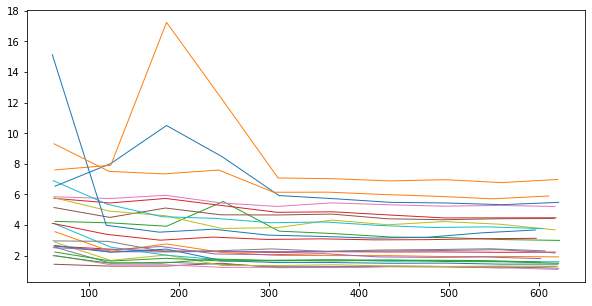

In [82]:
fig, ax = plt.subplots(1, figsize=(10,5))
for skn in df_result['skn'].unique():
    df_station = df_result.query(f'skn == {skn}')
    # ax.plot(df_station['n_data'], df_station['rmse_lr'], label='linear')
    ax.plot(df_station['n_data'], df_station['rmse_xgb'], label='xgb', linewidth=1)
    # ax.legend()

In [84]:
columns = C_SINGLE
df = pd.read_csv(FILENAME, usecols=C_COMMON + columns)
params = dict(n_estimators=100, learning_rate=0.039964, max_depth=4)
test_sizes = np.arange(0.1, 1.1, 0.1)
dfs = []
for skn in tqdm(df['skn'].unique()):
    # print('=======================================================')
    df_train = df.query(f'(skn == {skn}) & fold != 4')
    df_test = df.query(f'skn == {skn} & fold == 4')
    # print(f"There are {df_train.shape[0]} training data")
    # print(f"There are {df_test.shape[0]} test data")
    for test_size in test_sizes:
        n_training_data = int(df_train.shape[0] * test_size) # floor

        df_train_partial = df_train.iloc[:n_training_data]
        # print(f"There are {df_train_partial.shape[0]} training data")
        # print(f"There are {df_test.shape[0]} test data")
    
        x_train, x_test = np.array(df_train_partial[columns]), np.array(df_test[columns])
        y_train, y_test = np.array(df_train_partial['data_in']), np.array(df_test['data_in'])
        xgboost = XGBRegressor(**params)
        xgboost.fit(x_train, y_train)
        yhat_xgb = xgboost.predict(x_test)
        rmse_xgb = mean_squared_error(y_test, yhat_xgb, squared=False)

        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        yhat_lr = linear_regression.predict(x_test)
        rmse_lr = mean_squared_error(y_test, yhat_lr, squared=False)

        list_rmse_lr.append(rmse_lr)
        list_rmse_xgb.append(rmse_xgb)
        dfs.append(
            pd.DataFrame({
                'skn': [skn],
                'n_data': [n_training_data],
                'rmse_lr': [rmse_lr],
                'rmse_xgb': [rmse_xgb]
            })
        )

        # print(f"RMSE on Linear Regression: {rmse_lr: .3f}")
        # print(f"RMSE on XGBoost          : {rmse_xgb: .3f}")

100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


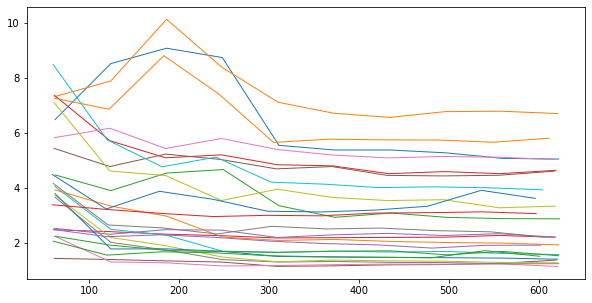

In [85]:
df_result_ = pd.concat(dfs)

fig, ax = plt.subplots(1, figsize=(10,5))
for skn in df_result_['skn'].unique():
    df_station = df_result_.query(f'skn == {skn}')
    # ax.plot(df_station['n_data'], df_station['rmse_lr'], label='linear')
    ax.plot(df_station['n_data'], df_station['rmse_xgb'], label='xgb', linewidth=1)
    # ax.legend()

In [257]:
def cross_val_predict(df: pd.DataFrame, model, skn: int, columns: list, verbose=False):
    """
    Runs cross_val_predict for a single skn, using XGB or LinearRegression.
    The same functionality as sklearn.model_selection.cross_val_predict,
    except the split is not exactly 1/5 (thus pre-determined by preprocessing).
    This is because the split has to be made in the way it won't separate samples in the same month into different folds.
        Args:
            :param df: dataset for evaluation. Must contain 'fold' column that specifies assignment of each sample to the folds.
            :param model: one of [sklearn.linear_models.LinearRegression, xgboost.XGBRegressor]
            :param skn: identifier for stations
            :param columns: list of str indicating which columns to use as input data for the model
    """
    assert 'fold' in df.columns, "Must contain a column 'fold' to specify assignment of samples to the folds."
    n_folds = len(df['fold'].unique())
    dfs = [] # list of dfs containing result for each fold
    
    iterator = tqdm(range(n_folds)) if verbose else range(n_folds)
    
    for fold in iterator:
        df_train = df.query(f'(fold != {fold}) & (skn == {skn})')
        df_test = df.query(f'(fold == {fold}) & (skn == {skn})')
        
        x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
        y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])
        
        model.fit(x_train, y_train)
        yhat = model.predict(x_test)
        
        _df = pd.DataFrame(
            {
                'skn' : df_test['skn'].values,
                'year': df_test['year'].values,
                'month': df_test['month'].values,
                'observed': df_test['data_in'].values,
                'prediction': yhat,
            }
        )
        dfs.append(_df)
        
    return pd.concat(dfs)

def parallelize(func, args, n_jobs=-1):
    """
    :param args: iterable. list of arguments for the function
    """
    if n_jobs == -1:
        pool = mp.Pool(mp.cpu_count())
    else:
        pool = mp.Pool(n_jobs)
    result_objects = [pool.apply_async(func, args=_args) for _args in args]
    pool.close()
    pool.join()
    return [r.get() for r in result_objects]

In [265]:
linear_regression = LinearRegression()
params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
xgboost = XGBRegressor(**params)

for skn in df['skn'].unique():
    print(f"experiment on {skn}")
    df_result = cross_val_predict(df, linear_regression, skn=skn, columns=columns, verbose=False)
    rmse = mean_squared_error(df_result['observed'], df_result['prediction'], squared=False)
    print(f'RMSE using LR: {rmse:.2f}')
    df_result = cross_val_predict(df, xgboost, skn=skn, columns=columns, verbose=False)
    rmse = mean_squared_error(df_result['observed'], df_result['prediction'], squared=False)
    print(f'RMSE using XGB: {rmse:3.2f}')
    print('=================================================================================')
    

experiment on 54.0
RMSE using LR: 5.18
RMSE using XGB: 5.60
experiment on 79.0
RMSE using LR: 6.00
RMSE using XGB: 6.76
experiment on 338.0
RMSE using LR: 4.21
RMSE using XGB: 4.62
experiment on 250.0
RMSE using LR: 2.05
RMSE using XGB: 2.22
experiment on 267.0
RMSE using LR: 2.22
RMSE using XGB: 2.33
experiment on 296.1
RMSE using LR: 1.51
RMSE using XGB: 1.62
experiment on 311.0
RMSE using LR: 1.36
RMSE using XGB: 1.43
experiment on 396.0
RMSE using LR: 1.55
RMSE using XGB: 1.56
experiment on 400.0
RMSE using LR: 1.62
RMSE using XGB: 1.67
experiment on 406.0
RMSE using LR: 1.78
RMSE using XGB: 1.83
experiment on 410.0
RMSE using LR: 1.71
RMSE using XGB: 1.80
experiment on 485.0
RMSE using LR: 2.20
RMSE using XGB: 2.27
experiment on 703.0
RMSE using LR: 1.95
RMSE using XGB: 2.02
experiment on 718.0
RMSE using LR: 5.10
RMSE using XGB: 5.43
experiment on 770.0
RMSE using LR: 2.19
RMSE using XGB: 2.39
experiment on 783.0
RMSE using LR: 4.40
RMSE using XGB: 4.78
experiment on 784.0
RMSE u